# MNIST Tutorial
In this tutorial, we will first use `tensorflow` and `keras` to build a simple fully connected neural network to perform hand written digit classification on MNIST dataset. Then we will dive into the details of how to write a neural network from scratch. Basically, we will re-implement the functionality of `keras` from scratch, without the help of tensorflow or any machine learning frameworks.

## Keras
Step one, let's build a simple sequential model using `keras` and we will see how powerful `keras` is. It should only take us less than 10 lines of code to build a 3-layer fully connected network.

In [1]:
import warnings
warnings.filterwarnings('ignore')

from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.utils import to_categorical
from keras.optimizers import SGD
from keras.regularizers import l2

from matplotlib import pyplot as plt

import numpy as np


# Build the neural network!
model = Sequential()
model.add(Dense(300, input_dim=28*28, kernel_regularizer=l2(0.01)))
model.add(Activation('relu'))
model.add(Dense(50, input_dim=300, kernel_regularizer=l2(0.01)))
model.add(Activation('relu'))
model.add(Dense(10, input_dim=100))
model.add(Activation('softmax'))

Using TensorFlow backend.


Now we will grab MNIST hand-written digit data through `keras`.

In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

Let's visualize them and see how do the data look like.

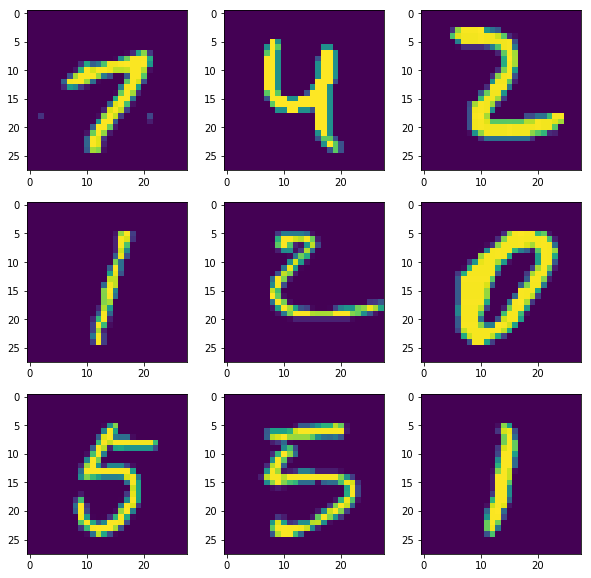

In [3]:
from utils import visualize_img_data

visualize_img_data(x_train)

Now here comes the magic of `keras`. We can train the network using as few as 3 lines of code!

Train on 48000 samples, validate on 12000 samples
Epoch 1/10
48000/48000 [==============================] - 4s 81us/step - loss: 1.9824 - acc: 0.8846 - val_loss: 0.6390 - val_acc: 0.9190
Epoch 2/10
48000/48000 [==============================] - 4s 78us/step - loss: 0.5175 - acc: 0.9269 - val_loss: 0.4547 - val_acc: 0.9336
Epoch 3/10
48000/48000 [==============================] - 4s 78us/step - loss: 0.4354 - acc: 0.9358 - val_loss: 0.4010 - val_acc: 0.9476
Epoch 4/10
48000/48000 [==============================] - 4s 86us/step - loss: 0.4049 - acc: 0.9431 - val_loss: 0.3878 - val_acc: 0.9457
Epoch 5/10
48000/48000 [==============================] - 4s 81us/step - loss: 0.3846 - acc: 0.9471 - val_loss: 0.3715 - val_acc: 0.9498
Epoch 6/10
48000/48000 [==============================] - 4s 91us/step - loss: 0.3729 - acc: 0.9494 - val_loss: 0.3645 - val_acc: 0.9508
Epoch 7/10
48000/48000 [==============================] - 4s 90us/step - loss: 0.3585 - acc: 0.9523 - val_loss: 0.3420 - val_acc

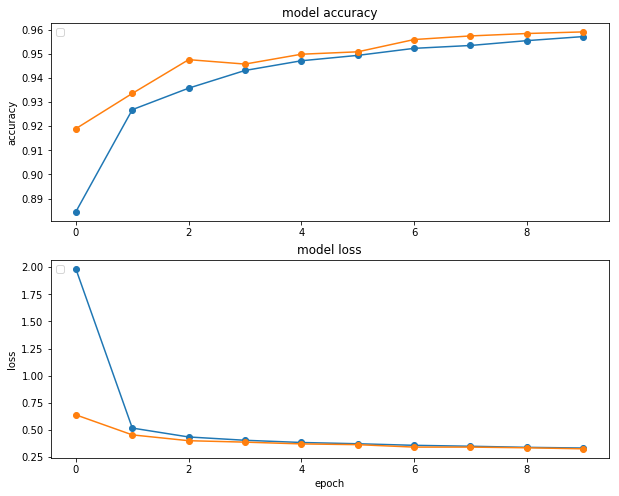

In [4]:
from utils import plot_histo_chart


# Massage the data first
N, H, W = x_train.shape
x = x_train.reshape((N,H*W)).astype('float') / 255
y = to_categorical(y_train, num_classes=10)

# Define optimizer
sgd = SGD(lr=0.01, decay=1e-4, momentum=0.9)

# Compile the model
model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])

# Train it
plot_histo_chart(model.fit(x, y, validation_split=0.20, epochs=10, batch_size=50))

Now training is done, we are ready to evaluate the model.

In [5]:
N, H, W = x_test.shape
x = x_test.reshape(N, H*W).astype('float') / 255
y = to_categorical(y_test, num_classes=10)

test_loss, test_acc = model.evaluate(x, y, batch_size=50)
print 'Accuracy on test data %f' % test_acc

10000/10000 [==============================] - 0s 35us/step
Accuracy on test data 0.957300


That is a 95.8% accuracy on test data! This isn't bad but it isn't the best. We can achieve 99.8% if we use convolutional neural network. This is a topic for another tutorial.

## Implement From Scratch
Now it is time to implement everything from scratch. The source code can be found on [GitHub][1]. We are going to deep dive into every detail of the implementation to get a full understanding of what's going on. It is important to understsand how to perform gradient calculation using the idea of a [computational graph][2] before we proceed onto writing code. In every layer, we will focus on calculating the local gradients and use chain rule to compute the gradient with respect to loss.

[1]:https://github.com/calvinfeng/machine-learning-notebook/tree/master/mnist_tutorial
[2]:http://colah.github.io/posts/2015-08-Backprop/

## Dense
The first layer we will implement is the `Dense` layer. We need logic for both forward propagation and backpropagation in this layer. 

### Forward Propagation
Let's begin with forward propagation:

$$
y = \vec{x}W + b
$$

$W$ is our weight matrix and $b$ is the bias vector. We take an input, which is $\vec{x}$, and perform an [affine][3] transformation on it. The input to our forward propagation function can be any shape, e.g. `(N, 28, 28, 3)`, this represents N 28x28 images with 3 channels (RGB). However, the weight matrix must be of shape `(28*28*3, H)` where H is the hidden unit dimension. Thus, the input needs to be reshaped before we carry out the matrix multiplication.
```python
    def forward_prop(self, x, w, b):
        self.input = x
        self.weight = w
        self.bias = b

        D = np.prod(x.shape[1:])
        x_reshaped = x.reshape(x.shape[0], D)

        return np.dot(x_reshaped, w) + b
```

[3]:https://en.wikipedia.org/wiki/Affine_transformation

### Backpropagation
It should be the layer's responsibility to compute local gradients and apply chain rule to them to obtain gradient of loss. What are local gradients? They are the gradient of $y$ with respect to $x$, $W$, and $b$, as opposed to the gradient of loss (which is global gradient in our context.)

$$
\frac{\partial y}{\partial W} = x^{T}
$$

$$
\frac{\partial y}{\partial x} = W^{T}
$$

$$
\frac{\partial y}{\partial b} = 1
$$

#### Tensor Calculus
Notice that we are doing tensor calculus, the actual derivation of differentiation isn't very clean. It involves constructing a Jacobian matrix because we are basically taking derivative of a vector i.e. $y$ with respect to a matrix, i.e. $W$. For more information, please look at [Prof. Erik Learned-Miller's note][4]. 

For now, let's look at a simple example to prove the equations above:

$$
\vec{x} = [x_{1}, x_{2}, x_{3}] \\
\vec{b} = [b_{1}, b_{2}]
$$

And

$$
W = \begin{bmatrix}
w_{1,1} & w_{1,2} \\ 
w_{2,1} & w_{2,2} \\
w_{3,1} & w_{3,2}
\end{bmatrix}
$$

Thus, $y$ is

$$
y = \begin{bmatrix}
w_{1,1}x_{1} + w_{2,1}x_{2} + w_{3,1}x_{3} & w_{1,2}x_{1} + w_{2,2}x_{2} + w_{3,2}x_{3}
\end{bmatrix}
$$

Now if we want to take derivative of $y$ with respect to $\vec{x}$, we need to construct a Jacobian.

$$
\frac{\partial y}{\partial \vec{x}} = \begin{bmatrix}
\frac{\partial y_{1}}{\partial x_{1}} & \frac{\partial y_{1}}{\partial x_{2}} & \frac{\partial y_{1}}{\partial x_{3}} \\
\frac{\partial y_{2}}{\partial x_{1}} & \frac{\partial y_{2}}{\partial x_{2}} & \frac{\partial y_{2}}{\partial x_{3}}
\end{bmatrix}
$$

That is equivalent to the transpose of weight matrix!

$$
\frac{\partial y}{\partial \vec{x}} = \begin{bmatrix}
w_{1,1} & w_{2,1} & w_{3,1} \\
w_{1,2} & w_{2,2} & w_{3,2} 
\end{bmatrix} = W^{T}
$$

#### Dimension Analysis
Anyways, my typical lazy approach to the problem is dimension analysis. We know that upstream gradient, the gradient of loss with respect to $y$ has the shape `(N, H)`. We know that $x$ has the shape `(N, D)`. We are expecting to get the gradient of $y$ with respect to $W$, which should have the shape of `(D, H)`. This is translating to the following in code:
```python
# Applying vector chain rule, as a result, grad_w is the gradient of loss with respect to weight
grad_w = np.dot(x.T, grad_y)  # (D, N) x (N, H) => (D, H)
```

Similarly, we can do the same for gradient of $x$:
```python
# Applying vector chain rule, as a result, grad_x is the gradient of loss with respect to input
grad_x = np.dot(grad_y, w.T)
```

Since the local gradient of bias is 1, the gradient of loss with respect to $y$ is going to be the gradient we use for updating biases. But the problem is that `grad_y` has shape `(N, H)` while bias vector has shape `(H,)`. this just means that we need to sum up the contributions from N examples.
```
grad_b = np.sum(grad_y.T, axis=1)
```

Now put everything together.
```python
    # grad_output is grad_y, I use the two terms interchangeably
    def backprop(self, grad_output):
        if self.input is not None and self.weight is not None:
            D = np.prod(self.input.shape[1:])
            input_reshaped = self.input.reshape(self.input.shape[0], D)

            grad_w = np.dot(input_reshaped.T, grad_output)
            grad_x = np.dot(grad_output, self.weight.T).reshape(self.input.shape)
            grad_b = np.sum(grad_output.T, axis=1)

            return grad_x, grad_w, grad_b  
```

[4]:https://compsci697l.github.io/docs/vecDerivs.pdf

## ReLU Activation
ReLU stands for rectified linear unit. It squashes all negative inputs to zero and keeps the value of all positive inputs. 
```python
relu(1)  # => 1
relu(52342)  # => 52342
relu(-1)  # => 0
relu(-4232)  # => 0
```

### Forward Propagation
$$
f(x) = \begin{cases}
\text{if } x > 0 \quad \text{ return } x \\  
\text{if } x <= 0 \quad \text{ return } 0 
\end{cases}
$$

The implementation is extremely simple.
```python
def forward_prop(self, x):
    return np.maximum(0, x)
```

### Back Propagation
ReLU acts as a switch. If any input is negative, it won't pass the input forward to next layer. If any input is positive, it will pass the input forward to next layer without any additional modifications. What does that imply? Whenever the input is positive, we have a slope of 1 because the change is linearly proportional to the input. This is like: 

$$
\text{ Given } f(x) = x \rightarrow \frac{\partial f}{\partial x} = 1
$$

Whenever the input is negative, we have a slope of zero because there isn't any change! This is like:

$$
\text{ Given } f(x) = 0 \rightarrow \frac{\partial f}{\partial x} = 0
$$

We can expect that our local gradient is filled with ones and zeros in a matrix of shape `(N, H)`. We will multiply the local gradient by the upstream gradient. With that mind, we can take a short cut and write:
```python
def backprop(self, grad_output):
    grad_input = grad_output
    grad_input[self.input <= 0] = 0  # Set all entries, where inputs were negative, to zero.
    
    return grad_input
```

## Softmax Activation
What is softmax? It is a generalization of the logistic function that allows us to handle multiple classes. To put it in layman term, it is a function that we can use to squash a set of random values with range `{-Inf, Inf}` to a range of `{0, 1}`. You may ask, why squashing? It is because squashing allows us to extract probabilities and likelihood from a set of values. 

For example, let's ask the question, given Dog, Cat, Hippo, and Parrot, which one is your favorite pet? You can arbitrarily assign some score to each of them, like
```
{
    "dog": 100,
    "cat": 100,
    "hippo": 70,
    "parrot": -100
}
```

For whatever reason you don't like parrot, because they are too talkative, you give it a negative score. 

### Quantifying Score
The problem with score is that it is completely arbitrary and it is meaningless to tell someone that "Dog and cat score 100 points". It is more meaningful to ask which one of them is most likely to be your favorite pet. 

Let's define score as an array

In [6]:
import numpy as np


pet_types = ['dog', 'cat', 'hippo', 'parrot']
pet_scores = [100, 100, 70, -100]

I will denote `s` as score for convenience. Softmax probability for a given `i` item is defined as follows

$$
P(i) = \frac{e^{s_{i}}}{\Sigma_{j}^{N} e^{s_{j}}}
$$

In [7]:
def probability(scores, i):
    exp_sum = 0
    for score in scores:
        exp_sum += np.exp(score)
    
    return np.exp(scores[i]) / exp_sum

Now we are ready to calculate probability using scores

In [8]:
for i in range(len(pet_types)):
    print "Probability of %s being your favorite pet is %f" % (pet_types[i], probability(pet_scores, i))

Probability of dog being your favorite pet is 0.500000
Probability of cat being your favorite pet is 0.500000
Probability of hippo being your favorite pet is 0.000000
Probability of parrot being your favorite pet is 0.000000


### Numerically Instability
The math expression above is fairly easy to understand, but it suffers from one problem: *numerical instability*. The probability function will blow up when the score value is too high.

Let me demonstrate with an example:

In [9]:
car_brands = ['mazda', 'porsche', 'hyundai']
car_scores = [100, 1000, 100]

probability(car_scores, 1)

nan

We get a `NaN` as answer! You know why? Because `np.exp(1000)` is tooooooo big to fit in memory. The computer cannot handle such big number. We need a way to get around this problem and allow our probability function to take in any score values otherwise it is garbage.

Stablize numerical instability by multiplying by 1. (This is a common trick that is used in many engineering fields and physics.)

$$
P(i) = \frac{C \cdot e^{s_{i}}}{C \cdot \Sigma_{j}^{N} e^{s_{j}}}
$$

Note that

$$
\frac{C}{C} = 1
$$

`C` is any arbitrary constant, be it `C = 1`, `C = 1000` or `C = 9999999`. Now we can rewrite the expression by doing a little algebra here. 

$$
P(i) = \frac{e^{s_{i} + log(C)}}{C \cdot \Sigma_{j}^{N} e^{s_{j} + log(C)}}
$$

A common choice for `log(C)` is `-1 * np.max(scores)`. Basically, we are subtracting all scores by the max score in the score array. It's a very simple trick.

In [10]:
def stable_probability(scores, i):
    max_score = np.max(scores)
    exp_sum = 0
    for score in scores:
        exp_sum += np.exp(score - max_score)
    
    return np.exp(scores[i] - max_score) / exp_sum


for i in range(len(car_brands)):
    print "Probability of %s being the best is %f" % (car_brands[i], stable_probability(car_scores, i))

Probability of mazda being the best is 0.000000
Probability of porsche being the best is 1.000000
Probability of hyundai being the best is 0.000000


## Cross Entropy Loss
Before we dive into the implementation of a softmax layer, we must establish what is the loss function we are going to use for this model. Since we are performing hand written digit classification, we will for sure put softmax as our last layer of activation, i.e. whatever we get out from the softmax layer is the result of our model. 

In the `keras` example above, we have this one line which specifies what kind of loss function and function optimizer the model is using.
```python
model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])
```

### Categorical Cross Entropy
The choice here is cross-entropy loss. It measures the performance of a classification model whose output is a probability value between 0 and 1. Cross entropy loss increases as the predicted probability diverges from the actual label. The loss for a given `ith` example is defined as follows:

$$
L_{i} = -log\left(P(y_{i})\right)
$$

What does that mean? Suppose the correct label is 3, and your predicted probability for class 3 is 1. The loss expression will give you a zero loss because `-1*log(1) = 0`. What if you predicited probability is 0? Then `-1*log(0)` will give you an infinity loss. Typically we use average loss because we often compute loss over multiple examples. 

$$
L = \frac{1}{N}\Sigma_{i=0}^{N} L_{i} = \frac{1}{N}\Sigma_{i=0}^{N} -log\left(P(y_{i})\right)
$$

## Back to Softmax
### Forward Propagation
The forward propagation will be very similar to what we implemented in the section above, except this time we will use vectorized approach to make it even more efficient.

```python
def forward_prop(self, x):
    shifted_logits = x - np.max(x, axis=1, keepdims=True)
    Z = np.sum(np.exp(shifted_logits), axis=1, keepdims=True)
    probs = np.exp(shifted_logits) / Z   
    
    return probs
```

### Back Propagation
The gradient of loss with respect to score has a very simple expression:

$$
\frac{\partial L_{i}}{\partial s_{k}} = \left\{ 
\begin{matrix}
\text{ if } y_{i} = k \quad p_{k} - 1 \\ 
\text{ else } \quad p_{k}
\end{matrix}
\right.
$$

**HOW TO INTERPRET**: For any given `ith` input, we expect to receive a score vector. We can call it `s` and use $s_{k}$ to represent `s[k]` where `k` is an index into the score vector.
Every score element is translated into probaility after softmax activation is applied. If the length of score vector`len(s)` is `K`, then the lenght of probability vector `len(probs)` is also `K`. 

In [11]:
# Here's an example in Python
score = np.array([12, 2, 1])
prob = np.exp(score) / np.sum(np.exp(score))
print 'Probability vector is', prob

# Let's assume that label y[i] is 0
y = 0
grad_score = prob.copy()
grad_score[y] -= 1
print 'Gradient of loss with respect to score is', grad_score

Probability vector is [  9.99937902e-01   4.53971105e-05   1.67006637e-05]
Gradient of loss with respect to score is [ -6.20977742e-05   4.53971105e-05   1.67006637e-05]


#### Derivation
By definition, categorical loss for a single input is:

$$
L = -log\left(\frac{e^{s_{y}}}{e^{s_{0}} + e^{s_{1}} + ... + e^{s_{y}} + ... + e^{K-1}}\right)
$$

When we take derivative, we are taking it with respect to the score vector. Again, this is tensor calculus.

$$
\frac{\partial L}{\partial \vec{s}} = 
\left \langle 
\frac{\partial L}{\partial s_{0}},
\frac{\partial L}{\partial s_{1}},
...,
\frac{\partial L}{\partial s_{y}},
...,
\frac{\partial L}{\partial s_{K-1}},
\right \rangle
$$

For example, let's take derivative of $s_{k}$ when $k \neq y$ using u-substitution.

$$
L = -log\left(u\right)
$$

and 

$$
u = e^{s_{y}}\left( e^{s_{0}} + e^{s_{1}} + ... + e^{s_{y}} + ... + e^{s_{K-1}}\right)^{-1}
$$

Now take derivative with respect to $u$.

$$
\frac{\partial L}{\partial u} = \frac{-1}{u}
$$

And take derivative of $u$ with respect to $s_{1}$ using product rule.

$$
\frac{\partial u}{\partial s_{1}} = 0 + (-1) e^{s_{y}}e^{s_{1}}\left( e^{s_{0}} + e^{s_{1}} + ... + e^{s_{y}} + ... + e^{s_{K-1}}\right)^{-2}
$$

Now use chain rule to compute the final result.

$$
\frac{\partial L}{\partial u}\frac{\partial u}{\partial s_{1}} = (-1)(-1)
\frac{e^{s_{y}}e^{s_{1}}\left( e^{s_{0}} + e^{s_{1}} + ... + e^{s_{y}} + ... + e^{s_{K-1}}\right)}{e^{s_{y}}\left( e^{s_{0}} + e^{s_{1}} + ... + e^{s_{y}} + ... + e^{s_{K-1}}\right)^{2}} = 
\frac{e^{s_{1}}}{\left( e^{s_{0}} + e^{s_{1}} + ... + e^{s_{y}} + ... + e^{s_{K-1}}\right)} = p_{1}
$$

QED, we have shown that if $y \neq k$, gradient of score at `k` is the probability at `k`. Let's move onto show derivation for when $y = k$. The only difference here is the product rule part.

$$
\frac{\partial u}{\partial s_{y}} = e^{s_{y}}\left( e^{s_{0}} + e^{s_{1}} + ... + e^{s_{y}} + ... + e^{s_{K-1}}\right)^{-1} - e^{s_{y}}e^{s_{y}}\left( e^{s_{0}} + e^{s_{1}} + ... + e^{s_{y}} + ... + e^{s_{K-1}}\right)^{-2}
$$

Now use chain rule again.

$$
\frac{\partial L}{\partial u}\frac{\partial u}{\partial s_{y}} = \frac{-e^{s_{y}}\left( e^{s_{0}} + e^{s_{1}} + ... + e^{s_{y}} + ... + e^{s_{K-1}}\right)}{e^{s_{y}}\left( e^{s_{0}} + e^{s_{1}} + ... + e^{s_{y}} + ... + e^{s_{K-1}}\right)} + \frac{e^{s_{y}}e^{s_{y}}\left( e^{s_{0}} + e^{s_{1}} + ... + e^{s_{y}} + ... + e^{s_{K-1}}\right)}{e^{s_{y}}\left( e^{s_{0}} + e^{s_{1}} + ... + e^{s_{y}} + ... + e^{s_{K-1}}\right)^{2}} = p_{k} - 1
$$

## Put Everything Together
Finally we are ready to put everything together. I will leave this as an exercise to reader for constructing his/her own model using the layers implemented in this tutorial. I will showcase what I've built.

In [12]:
# Everything from this tutorial
from models.loss import categorical_cross_entropy
from layers import Dense, ReLU, Softmax
from models import Sequential
from optimizers import GradientDescent

# Keras
from keras.datasets import mnist
from keras.utils import to_categorical

import numpy as np

(x_train, y_train), (x_test, y_test) = mnist.load_data()
print 'Imported MNIST data: training input %s and training labels %s.' % (x_train.shape, y_train.shape)
print 'Imported MNIST data: test input %s and test labels %s.' % (x_test.shape, y_test.shape)

N, H, W = x_train.shape
x = x_train.reshape((N,H*W)).astype('float') / 255
y = to_categorical(y_train, num_classes=10)

model = Sequential()
model.add(Dense(), ReLU(), layer_dim=(28*28, 300), weight_scale=1e-2)
model.add(Dense(), ReLU(), layer_dim=(300, 100), weight_scale=1e-2)
model.add(Dense(), Softmax(), layer_dim=(100, 10), weight_scale=1e-2)

model.compile(optimizer=GradientDescent(learning_rate=1e-2),loss_func=categorical_cross_entropy)
model.fit(x, y, epochs=10, batch_size=50, verbose=False)    

Imported MNIST data: training input (60000, 28, 28) and training labels (60000,).
Imported MNIST data: test input (10000, 28, 28) and test labels (10000,).
Epoch (1/10) training accuracy: 0.200000 and training loss 2.302445
Epoch (2/10) training accuracy: 0.900000 and training loss 0.253407
Epoch (3/10) training accuracy: 0.980000 and training loss 0.199864
Epoch (4/10) training accuracy: 0.920000 and training loss 0.168803
Epoch (5/10) training accuracy: 1.000000 and training loss 0.041192
Epoch (6/10) training accuracy: 0.960000 and training loss 0.088683
Epoch (7/10) training accuracy: 1.000000 and training loss 0.029964
Epoch (8/10) training accuracy: 1.000000 and training loss 0.030463
Epoch (9/10) training accuracy: 0.980000 and training loss 0.055227
Epoch (10/10) training accuracy: 1.000000 and training loss 0.020520
Epoch (11/10) training accuracy: 1.000000 and training loss 0.011982


In [14]:
N, H, W = x_test.shape
x = x_test.reshape((N,H*W)).astype('float') / 255
y = to_categorical(y_test, num_classes=10)

loss, acc = model.evaluate(x, y)
print 'Final loss: %f and accuracy on test dataset: %f' % (loss, acc)

Final loss: 0.078131 and accuracy on test dataset: 0.978700
